# Find biological motifs

To make sure our sampling strategy makes sense, we manually enter a few biological motifs.
We then look for these motifs in a large random sample, as well as in a large biological random sample.
If everything is correct, we should find the real motifs more frequently in the latter sample than in the former.

In [1]:
from discrete_motif import DiscreteGrnMotif
import discrete_motif_generator as generator
import discrete_motif_plotting as visualize

from copy import deepcopy
import numpy as np
import os
import pickle
import random

In [2]:
# define a few motifs
real_motifs = []

In [3]:
# load data back, start from this step to use previous run
directory = "../../data"
    
samples = []
for root, dirnames, filenames in os.walk(directory):
    for filename in filenames:
        if filename.endswith('.pkl'):
            with open(os.path.join(root, filename), 'rb') as input:
                samples.append(pickle.load(input))
                

In [4]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], samples[i]["random_tables"][0][2][-1][0])
    print("Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge" % args)
    sample_random = []
    sample_bio = []
    
    for sample in samples[i]["random_tables"]:
        sample_random.append(sample[0])
    for sample in samples[i]["bio_tables"]:
        sample_bio.append(sample[0])

    bio_total = 0
    random_total = 0
    bio_matched_motifs = []
    random_matched_motifs = []
    
    # to test, it seems to work :)
    # can we find the real thing?
    real_motifs = [sample_random[0]]
    # can we find a shuffled version?
    permuted_motif = deepcopy(real_motifs[0])
    mapping = list(range(0, permuted_motif.grn_vars["gene_cnt"]))
    random.shuffle(mapping)
    print("Shuffled to %s" % (mapping))
    permuted_table = permuted_motif.permute_transition_table(mapping)
    permuted_motif.transition_table = permuted_table
    real_motifs.append(permuted_motif)
    
    for real_motif in real_motifs:
        random_matches = real_motif.find_in_sample(sample_random, strict=False)
        bio_matches = real_motif.find_in_sample(sample_bio, strict=False)

        if len(random_matches) > 0:
            random_total += len(random_matches)
            random_matched_motifs.append(real_motif)
        if len(bio_matches) > 0:
            bio_total += len(bio_matches)
            bio_matched_motifs.append(real_motif)

    args = (bio_total, len(bio_matched_motifs), len(real_motifs))
    print("Found %d matches in the bio sample, for a total of %d out of %d real motifs." % args)
    args = (random_total, len(random_matched_motifs), len(real_motifs))
    print("Found %d matches in the random sample, for a total of %d out of %d real motifs." % args)

Using 4 nodes, 3-valued logic, and 0.5-epsilon 4-target nudge
Shuffled to [3, 2, 1, 0]
Found 0 matches in the bio sample, for a total of 0 out of 2 real motifs.
Found 2 matches in the random sample, for a total of 2 out of 2 real motifs.
Using 4 nodes, 3-valued logic, and 0.5-epsilon 4-target nudge
Shuffled to [0, 3, 2, 1]
Found 0 matches in the bio sample, for a total of 0 out of 2 real motifs.
Found 2 matches in the random sample, for a total of 2 out of 2 real motifs.
Using 4 nodes, 2-valued logic, and 0.5-epsilon 4-target nudge
Shuffled to [2, 3, 0, 1]
Found 0 matches in the bio sample, for a total of 0 out of 2 real motifs.
Found 2 matches in the random sample, for a total of 2 out of 2 real motifs.
Using 4 nodes, 2-valued logic, and 0.5-epsilon 4-target nudge
Shuffled to [0, 3, 2, 1]
Found 0 matches in the bio sample, for a total of 0 out of 2 real motifs.
Found 2 matches in the random sample, for a total of 2 out of 2 real motifs.


# Finding cycles in our samples

Using 4 nodes, 3-valued logic, and 0.5-epsilon 4-target nudge


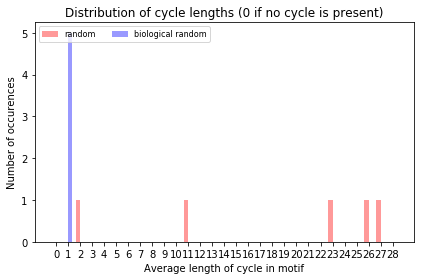

Using 4 nodes, 3-valued logic, and 0.5-epsilon 4-target nudge


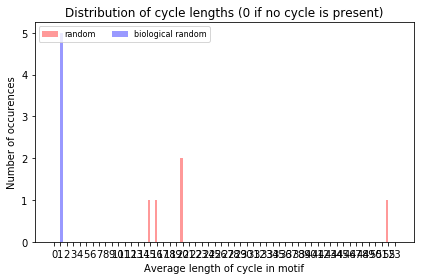

Using 4 nodes, 2-valued logic, and 0.5-epsilon 4-target nudge


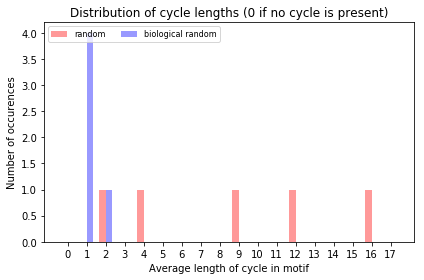

Using 4 nodes, 2-valued logic, and 0.5-epsilon 4-target nudge


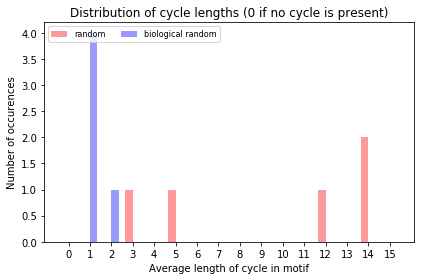

In [5]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], sample[2][-1][0])
    print("Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge" % args)
    random_cycles = []
    bio_cycles = []
    for sample in samples[i]["random_tables"]:
        lengths = [len(x) for x in sample[0].is_cyclical()]
        if len(lengths) == 0:
            lengths = [0]
        avg_length = int(np.mean(lengths))
        random_cycles.append(avg_length)
    for sample in samples[i]["bio_tables"]:
        lengths = [len(x) for x in sample[0].is_cyclical()]
        if len(lengths) == 0:
            lengths = [0]
        avg_length = int(np.mean(lengths))
        bio_cycles.append(avg_length)
    
    colors = ["r", "b"]
    labels = ["random", "biological random"]
    title = "Distribution of cycle lengths (0 if no cycle is present)"
    axes_labels = ["Average length of cycle in motif", "Number of occurences"]
    visualize.plot_bar([random_cycles, bio_cycles], colors, labels, title, axes_labels=axes_labels)

# Examine a few motifs (draw)

In [6]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"])
    print("\nUsing %s nodes, %s-valued logic" % args)
    counter = 0
    for sample in samples[i]["bio_tables"]:
        print("\nExamining sample %d" % counter)
        print(sample[0].grn_vars["rules"])
        counter += 1
        if counter ==  10:
            break


Using 4 nodes, 3-valued logic

Examining sample 0
[{'inputs': [0], 'rulefunction': <function plus at 0x7fe3ff200410>, 'outputs': [1]}]

Examining sample 1
[{'inputs': [1], 'rulefunction': <function minus at 0x7fe3ff200488>, 'outputs': [0]}]

Examining sample 2
[{'inputs': [0], 'rulefunction': <function plus at 0x7fe3ff200410>, 'outputs': [1]}]

Examining sample 3
[{'inputs': [1], 'rulefunction': <function minus at 0x7fe3ff200488>, 'outputs': [0]}]

Examining sample 4
[{'inputs': [1], 'rulefunction': <function minus at 0x7fe3ff200488>, 'outputs': [0]}]

Using 4 nodes, 3-valued logic

Examining sample 0
[{'inputs': [0], 'rulefunction': <function minus at 0x7fe3ff200488>, 'outputs': [1]}]

Examining sample 1
[{'inputs': [0, 1], 'rulefunction': <function plus_and at 0x7fe3ff200578>, 'outputs': [1]}]

Examining sample 2
[{'inputs': [1], 'rulefunction': <function plus at 0x7fe3ff200410>, 'outputs': [0]}]

Examining sample 3
[{'inputs': [1], 'rulefunction': <function minus at 0x7fe3ff200488>

# Examine a few initial matrices

In [7]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"])
    print("\nUsing %s nodes, %s-valued logic" % args)
    counter = 0
    for sample in samples[i]["bio_tables"]:
        print("\nExamining sample %d" % counter)
        print(sample[0].grn_vars["correlations"])
        counter += 1
        if counter == 3:
            break
    counter = 0
    for sample in samples[i]["bio_tables"]:
        print("\nExamining sample %d" % counter)
        print(sample[0].grn_vars["correlations"])
        counter += 1
        if counter == 3:
            break


Using 4 nodes, 3-valued logic

Examining sample 0
[[0.11731945247424536, -0.1701944943035183, -0.10131436196494226, 0.20565412749319867], [-0.1701944943035183, -0.09060118240700565, 0.08396127232213413, 0.4466232936754182], [-0.10131436196494226, 0.08396127232213413, 1.0, -0.11897498339963411], [0.20565412749319867, 0.4466232936754182, -0.11897498339963411, 0.4392149076090499]]

Examining sample 1
[[1.0, -0.027442686546060524, 0.44367042358795383, -0.3293535369299342], [-0.027442686546060524, -0.16805288073052704, -0.47759958300027927, 0.0011259785264516875], [0.44367042358795383, -0.47759958300027927, 0.24044387000099698, -0.6307272226769798], [-0.3293535369299342, 0.0011259785264516875, -0.6307272226769798, 0.19347139708000927]]

Examining sample 2
[[0.24034446764288936, -0.31956468104703517, 0.131299853598837, -0.14749803868605332], [-0.31956468104703517, -0.3189901901343084, 0.2729422000811492, -0.1446680590218815], [0.131299853598837, 0.2729422000811492, -0.19850752924239168, -0.

# Known cases (transition tables)

Valideer measures op wat random motieven: synergy/and/copy.

In [15]:
import discrete_motif_measures as measures
import discrete_motif_operations as operations

# XOR
motif = generator.generate_random(samplesize=1, no_nodes=2, numvalues=2)[0]
motif.transition_table = [[1, 1, 1, 0],[1, 0, 1, 1], [0, 1, 1, 1], [0, 0, 1, 0]]
motif.evaluate_motif()
print("The states: ")
for state in motif.states:
    print(state)
print("The correlations: ")
print(motif.grn_vars["correlations"])
print("Transitions: ")
print(motif.transition_table)

print("The entropy: ")
print(motif.entropy())
print("The mutual information: ")
print(measures.mutual_information(motif))
print("The WMS information: ")
print(measures.synergy_wms(motif))
print("The middle ground synergy approximation: ")
print(measures.synergy_middleground(motif))
print("The memory: ")
motif.reset_to_state(0)
print(measures.mi_decay(motif, 1))
motif.reset_to_state(0)
operations.nudge_variable(motif, [0], 0.5, 'DJ')
motif.evaluate_motif()
print("The nudge impact: ")
print(measures.hellinger(motif.states[1], motif.states[-1]))

The states: 
[[ 0.27737754  0.26803138]
 [ 0.10598928  0.3486018 ]]
[[ 0.0  0.0]
 [ 0.62597934  0.37402066]]
The correlations: 
[[0.2760169097292502, 0.051276775139931896], [0.051276775139931896, 1.0]]
Transitions: 
[[1, 1, 1, 0], [1, 0, 1, 1], [0, 1, 1, 1], [0, 0, 1, 0]]
The entropy: 
1.89549286348
The mutual information: 
0.953709312501
The WMS information: 
0.892149815104
The middle ground synergy approximation: 
1.36769201167
The memory: 
[1.8954928634803636, 0.95370931250128223808]
The nudge impact: 
0.383960535336


In [17]:
# COPY
motif = generator.generate_random(samplesize=1, no_nodes=2, numvalues=2)[0]
motif.transition_table = [[1, 1, 1, 1],[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 0, 0]]
motif.evaluate_motif()
print("The states: ")
for state in motif.states:
    print(state)
print("The correlations: ")
print(motif.grn_vars["correlations"])
print("Transitions: ")
print(motif.transition_table)

print("The entropy: ")
print(motif.entropy())
print("The mutual information: ")
print(measures.mutual_information(motif))
print("The WMS information: ")
print(measures.synergy_wms(motif))
print("The middle ground synergy approximation: ")
print(measures.synergy_middleground(motif))
print("The memory: ")
motif.reset_to_state(0)
print(measures.mi_decay(motif, 1))
motif.reset_to_state(0)
operations.nudge_variable(motif, [0], 0.5, 'DJ')
motif.evaluate_motif()
print("The nudge impact: ")
print(measures.hellinger(motif.states[1], motif.states[-1]))

The states: 
[[ 0.25154097  0.31969823]
 [ 0.04658345  0.38217736]]
[[ 0.25154097  0.31969823]
 [ 0.046583447  0.38217736]]
The correlations: 
[[0.3398257725450906, -0.11120374841407887], [-0.11120374841407887, 1.0]]
Transitions: 
[[1, 1, 1, 1], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 0, 0]]
The entropy: 
1.76325408486
The mutual information: 
1.76325408486
The WMS information: 
0.338454405436
The middle ground synergy approximation: 
0.558200930397
The memory: 
[1.7632540848567304, 1.7632540848567304414]
The nudge impact: 
0.414341358251


In [18]:
# AND
motif = generator.generate_random(samplesize=1, no_nodes=2, numvalues=2)[0]
motif.transition_table = [[1, 1, 1, 1],[1, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
motif.evaluate_motif()
print("The states: ")
for state in motif.states:
    print(state)
print("The correlations: ")
print(motif.grn_vars["correlations"])
print("Transitions: ")
print(motif.transition_table)

print("The entropy: ")
print(motif.entropy())
print("The mutual information: ")
print(measures.mutual_information(motif))
print("The WMS information: ")
print(measures.synergy_wms(motif))
print("The middle ground synergy approximation: ")
print(measures.synergy_middleground(motif))
print("The memory: ")
motif.reset_to_state(0)
print(measures.mi_decay(motif, 1))
motif.reset_to_state(0)
operations.nudge_variable(motif, [0], 0.5, 'DJ')
motif.evaluate_motif()
print("The nudge impact: ")
print(measures.hellinger(motif.states[1], motif.states[-1]))

The states: 
[[ 0.02889083  0.36973714]
 [ 0.56383246  0.03753957]]
[[ 0.39862797  0.0]
 [ 0.56383246  0.037539571]]
The correlations: 
[[0.25676660501415505, -0.06604172709543943], [-0.06604172709543943, 1.0]]
Transitions: 
[[1, 1, 1, 1], [1, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
The entropy: 
1.32232212534
The mutual information: 
1.17279869254
The WMS information: 
-0.21010612177
The middle ground synergy approximation: 
0.0710368274294
The memory: 
[1.3223221253436068, 1.1727986925414013035]
The nudge impact: 
0.271919253894
